In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
#To determine if your system supports CUDA
print("==> Check devices..")
if torch.cuda.is_available():
    device = 'cuda'
else:    
    device = 'cpu'
print("Current device: ",device)
if device == 'cuda':
    print("Our selected device: ", torch.cuda.current_device())
    print(torch.cuda.device_count(), " GPUs is available")

==> Check devices..
Current device:  cuda
Our selected device:  0
1  GPUs is available


In [4]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:, i, :, :].mean()
            std[i] += inputs[:, i, :, :].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

calculate_mean_std = False

if calculate_mean_std == True:
    #we will calculate mean and std
    #The transform function for train data
    transform_train = transforms.Compose([
        transforms.ToTensor(),
    ])

    transform_val = transforms.Compose([
        transforms.ToTensor(),
    ])

    #The transform function for test data
    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    trainset = torchvision.datasets.ImageFolder(root='../data/cinic10/aug-18000', transform=transform_train)
    valset = torchvision.datasets.ImageFolder(root='../data/cinic10/valid-224', transform=transform_val)
    testset = torchvision.datasets.ImageFolder(root='../data/cinic10/test-224', transform=transform_test)

    train_mean, train_std = get_mean_and_std(trainset)
    print(train_mean, train_std)
    val_mean, val_std = get_mean_and_std(valset)
    print(val_mean, val_std)
    test_mean, test_std = get_mean_and_std(testset)
    print(test_mean, test_std)
else:
    train_mean, train_std = ([0.4739, 0.4673, 0.4268]), ([0.1979, 0.1957, 0.1974])
    val_mean, val_std = ([0.4786, 0.4718, 0.4299]), ([0.1906, 0.1873, 0.1907])
    test_mean, test_std = ([0.4787, 0.4722, 0.4304]), ([0.1907, 0.1874, 0.1909])

In [5]:
train_mean, train_std = ([0.4739, 0.4673, 0.4268]), ([0.1979, 0.1957, 0.1974])
val_mean, val_std = ([0.4786, 0.4718, 0.4299]), ([0.1906, 0.1873, 0.1907])
test_mean, test_std = ([0.4787, 0.4722, 0.4304]), ([0.1907, 0.1874, 0.1909])
    
#The transform function for train data
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

#The transform function for validation data
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(val_mean, val_std)
])

#The transform function for test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(test_mean, test_std)
])

trainset = torchvision.datasets.ImageFolder(root='../data/cinic10/aug-18000', transform=transform_train)
valset = torchvision.datasets.ImageFolder(root='../data/cinic10/valid-224', transform=transform_val)
testset = torchvision.datasets.ImageFolder(root='../data/cinic10/test-224', transform=transform_test)

bs = 8
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs,
    shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=bs,
    shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=bs,
    shuffle=False, num_workers=2)

In [6]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
import glob
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

root = '../data/'
sets = {'train': 'aug-18000', 'valid': 'valid-224', 'test': 'test-224'}
#sets = {'train': 's1', 'valid': 's2', 'test': 's3'}
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
#classes = ('c1', 'c2')


data_path = root+'cinic10'

for s in sets:
    data, label = [], []
    for c in classes:
        source_directory = '{}/{}/{}'.format(data_path, sets[s], c)
        #print("{}".format(source_directory))
        filenames = glob.glob('{}/*.png'.format(source_directory))
        i = 0
        for fn in filenames:
            img = Image.open(fn).convert('RGB')
            img = np.array(img)
            #plt.imshow(img)
            #plt.show()
            data.append(img)
            #print("{}-index: {}".format(i, classes.index(c)))
            i += 1
            if((i%1000) == 999):
                print("set: {}, class: {}, progress --- {}".format(sets[s], c, i+1))
            label.append(classes.index(c))
                        
    np.savez(s+'.npz', data=data, label=label)

x = np.arange(10)
y = np.sin(x)

npzfile = np.load("../data/cinic10/test.npz")

print(npzfile.files)
#print(npzfile['data'])
print(npzfile['label'])

data = npzfile['data']
label = npzfile['label']

def getitem(index):
    img, target = data[index], label[index]
    return img, target

for i in [0, 1]:
    img, target = getitem(i)
    print("class: {}".format(target))
    plt.imshow(img)
    plt.show()

In [10]:
class CINIC10_NPZ(torch.utils.data.Dataset):
    def __init__(self, root='../data/cinic10/', train=True,
                          transform=None, target_transform=None, autogen=True):
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set
        self.autogen = autogen
        self.data = []
        self.label = []
        file_name = self.root
        entry = np.load(file_name)
        self.data = entry['data']
        self.label = entry['label']
        #print("{}".format(self.label[0]))
        #plt.imshow(self.data[0])
        #plt.show()
        #print("{}".format(self.label[1]))
        #plt.imshow(self.data[1])
        #plt.show()

    def __getitem__(self, index):
        #print('index: {}'.format(index))
        img, label = self.data[index], self.label[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        #print("label: {}".format(label))
        #plt.imshow(img)
        #plt.show()
        return img, label

    def __len__(self):
        return len(self.data)
    
trainset = CINIC10_NPZ(root='../data/cinic10/train.npz', transform=transform_train)
valset = CINIC10_NPZ(root='../data/cinic10/valid.npz', transform=transform_val)
testset = CINIC10_NPZ(root='../data/cinic10/test.npz', transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
    shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(valset, batch_size=1,
    shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
    shuffle=False, num_workers=0)


MemoryError: 

In [ ]:
import torch.nn as nn

In [ ]:
model = torchvision.models.resnet18(pretrained=False)
if device == 'cuda':
    model = model.cuda(0)
else:
    model = model.cpu()

In [ ]:
import torch.optim as optim

#loss function
criterion = nn.CrossEntropyLoss()
#optimization algorithm
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

In [ ]:
for phase in ['train', 'val']:
    if phase == 'train':
        print(phase)    
    else:
        print(phase)

In [ ]:
import copy

best_model = model
best_acc = 0.0
val_acc = 0.0
print(device)

model.train()
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, verbose=True)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma=0.5)

for epoch in range(200):  # loop over the dataset multiple times
        
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train(True)  # Set model to training mode
            dset_loaders = trainloader
        else:
            model.train(False)  # Set model to evaluate mode
            dset_loaders = valloader
            
        running_loss = 0.0
        correct = 0
        
        for i, data in enumerate(dset_loaders, 0):
        
            (inputs, labels) = data
            
            #change the type into cuda tensor 
            if device == 'cuda':
                inputs = inputs.cuda(0)
                labels = labels.cuda(0)
            else:
                inputs = inputs.cpu()
                labels = labels.cpu()

            #print(labels)
            #print(inputs)
        
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            # select the class with highest probability
            _, pred = outputs.max(1)
            # if the model predicts the same results as the true
            # label, then the correct counter will plus 1
            correct += pred.eq(labels).sum().item()
        
            loss = criterion(outputs, labels)
        
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i % 200) == 199:    # print every 200 mini-batches
                print('[%d, %5d]' % (epoch + 1, i + 1))
            
        if phase == 'train':
            epoch_loss = running_loss / len(trainset)
            epoch_acc = correct / len(trainset)
        else:
            epoch_loss = running_loss / len(valset)
            epoch_acc = correct / len(valset)
            val_acc = epoch_acc

        print('{:d} Epoch {} Loss: {:.4f} Acc: {:.4f}'.format(epoch, phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model = copy.deepcopy(model)
            torch.save(best_model, './model.pt')
    lr_scheduler.step(val_acc)
print('Finished Training')

model = best_model

In [22]:
model = best_model
print('==> Saving model..')

#only save model parameters
torch.save(model.state_dict(), './checkpoint.t7')
#you also can store some log information
state = {
    'net': model.state_dict(),
    'acc': 100.*correct/len(trainset),
    'epoch': epoch
}
torch.save(state, './checkpoint.t7')

#save entire model
torch.save(model, './model.pt')

print('Finished Saving')

==> Saving model..
Finished Saving


In [23]:
#If you save the entire model
model = torch.load('./model.pt')

print('Finished Loading')

Finished Loading


In [24]:
print('==> Testing model..')
model.eval()

==> Testing model..


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [25]:
correct = 0
total = 0
running_loss = 0.0
# device == 'cpu'
class_correct = list(0. for i in range(11))
class_total = list(0. for i in range(11))

with torch.no_grad():
    for mini_batch, data in enumerate(testloader, 0):
        images, labels = data

        if device == 'cuda':
            images = images.cuda(0)
            labels = labels.cuda(0)
        else:
            images = images.cpu()
            labels = labels.cpu()
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        running_loss += loss.item()

        c = (predicted == labels).squeeze()
        #print(predicted)
        #print(labels.size(0))
        #print(c)
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
        if(mini_batch % 200 == 199):
            print('[%5d]' % (mini_batch + 1))
            
print('Accuracy of the network on the %d test images: %.2f%%, and loss is: %.3f'
      % (total, 100 * correct / total, running_loss / total))

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 26 test images: 88.46%, and loss is: 0.911
Accuracy of    c1 : 100 %
Accuracy of    c2 : 50 %


/home/ccma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:34: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


IndexError: tuple index out of range

In [114]:
import os
import sys
import re
from collections import OrderedDict

def train_acc_loss_result(fname):

    dictionary_acc = OrderedDict()
    dictionary_best = OrderedDict()
    dictionary_loss = OrderedDict()
    dictionary_lr = OrderedDict()
    
    with open(fname) as fp:  
        best = 0
        
        for cnt, line in enumerate(fp):
            # print("Line {}: {}".format(cnt, line))
            # 199 Epoch val Loss: 0.0798 Acc: 0.8258
            pattern = re.compile(r"(\d+) Epoch val Loss: (\d+.\d+) Acc: (\d+.\d+)")
            match = pattern.match(line)
            if match:
                epoch_str, loss_str, acc_str = match.groups()
                print('Validation --- Epoch: {:s}, loss: {:s}, acc: {:s}'.
                      format(epoch_str, loss_str, acc_str))

                Epoch = int(epoch_str)
                loss = float("{:f}".format(float(loss_str)))
                acc = float("{:f}".format(float(acc_str)))
                
                if(best < acc):
                    best = acc
                    
                dictionary_best[Epoch] = best
                
            # 199 Epoch train Loss: 0.0008 Acc: 0.9998
            pattern = re.compile(r"(\d+) Epoch train Loss: (\d+.\d+) Acc: (\d+.\d+)")
            match = pattern.match(line)
            if match:
                epoch_str, loss_str, acc_str = match.groups()
                print('Training --- Epoch: {:s}, loss: {:s}, acc: {:s}'.
                      format(epoch_str, loss_str, acc_str))

                Epoch = int(epoch_str)
                loss = float("{:f}".format(float(loss_str)))
                acc = float("{:f}".format(float(acc_str)))
                
                dictionary_acc[Epoch] = acc
                dictionary_loss[Epoch] = loss

            # Epoch    56: reducing learning rate of group 0 to 2.4300e-05.
            pattern = re.compile(r"Epoch    (\d+): reducing learning rate of group 0 to (\d+.\d+e-\d+).")
            match = pattern.match(line)
            if match:
                epoch_str, lr_str = match.groups()
                print('Learning Rate --- Epoch: {:s}, lr: {:s}'.
                      format(epoch_str, lr_str))

                Epoch = int(epoch_str)
                lr = float("{0:f}".format(float(lr_str)))
                
                dictionary_lr[Epoch] = lr
                
    return dictionary_best, dictionary_acc, dictionary_loss, dictionary_lr

In [118]:
import matplotlib.pyplot as plt
import itertools

def show_train_acc(dictionary_best, dictionary_acc, dictionary_loss, dictionary_lr):
    fig, ax1 = plt.subplots()

    fig.set_figheight(20)
    fig.set_figwidth(20)

    ax1.set_title('Training/Validation Accuracy & Loss / Learning Rate', fontsize=20)

    ax2 = ax1.twinx()
    ax2.figure.figsize=(120,120)
    
    l1, = ax1.plot(list(dictionary_best.keys()), list(dictionary_best.values()), 'g-')
    l2, = ax1.plot(list(dictionary_acc.keys()), list(dictionary_acc.values()), 'b-')
    l3, = ax2.plot(list(dictionary_loss.keys()), list(dictionary_loss.values()), 'r--')
    l4, = ax2.plot(list(dictionary_lr.keys()), list(dictionary_lr.values()), 'ro')
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='y', which='major', labelsize=20)

    ax1.set_xlabel('Epoch', fontsize=20)
    ax1.set_ylabel('Accuracy', fontsize=20, color='#008888')
    ax2.set_ylabel('Loss / rate', fontsize=20, color='r')
    ax2.set_yscale("log", nonposy='clip')

    #ax1.set(ylim=[0, 100])
    #ax2.set(ylim=[0, 0.2])
    
    ax1.grid(axis='both', which='both')
    plt.legend(handles=[l1, l2, l3, l4],
               labels=['Best Accuracy', 'Train Accuracy', 'Loss', 'learning rate'], fontsize=20, loc='right')

    plt.show()

In [119]:
fname = './fp-1 v6.log'
dictionary_best, dictionary_acc, dictionary_loss, dictionary_lr = train_acc_loss_result(fname)

Training --- Epoch: 0, loss: 0.1896, acc: 0.4503
Validation --- Epoch: 0, loss: 0.1509, acc: 0.5718
Training --- Epoch: 1, loss: 0.1519, acc: 0.5709
Validation --- Epoch: 1, loss: 0.1552, acc: 0.5599
Training --- Epoch: 2, loss: 0.1428, acc: 0.5986
Validation --- Epoch: 2, loss: 0.1535, acc: 0.5717
Training --- Epoch: 3, loss: 0.1389, acc: 0.6105
Validation --- Epoch: 3, loss: 0.1324, acc: 0.6314
Training --- Epoch: 4, loss: 0.1372, acc: 0.6163
Validation --- Epoch: 4, loss: 0.1476, acc: 0.5939
Training --- Epoch: 5, loss: 0.1359, acc: 0.6207
Validation --- Epoch: 5, loss: 0.1231, acc: 0.6596
Training --- Epoch: 6, loss: 0.1355, acc: 0.6213
Validation --- Epoch: 6, loss: 0.1327, acc: 0.6257
Training --- Epoch: 7, loss: 0.1348, acc: 0.6234
Validation --- Epoch: 7, loss: 0.1242, acc: 0.6570
Training --- Epoch: 8, loss: 0.1343, acc: 0.6243
Validation --- Epoch: 8, loss: 0.1187, acc: 0.6686
Training --- Epoch: 9, loss: 0.1341, acc: 0.6255
Validation --- Epoch: 9, loss: 0.1324, acc: 0.6232


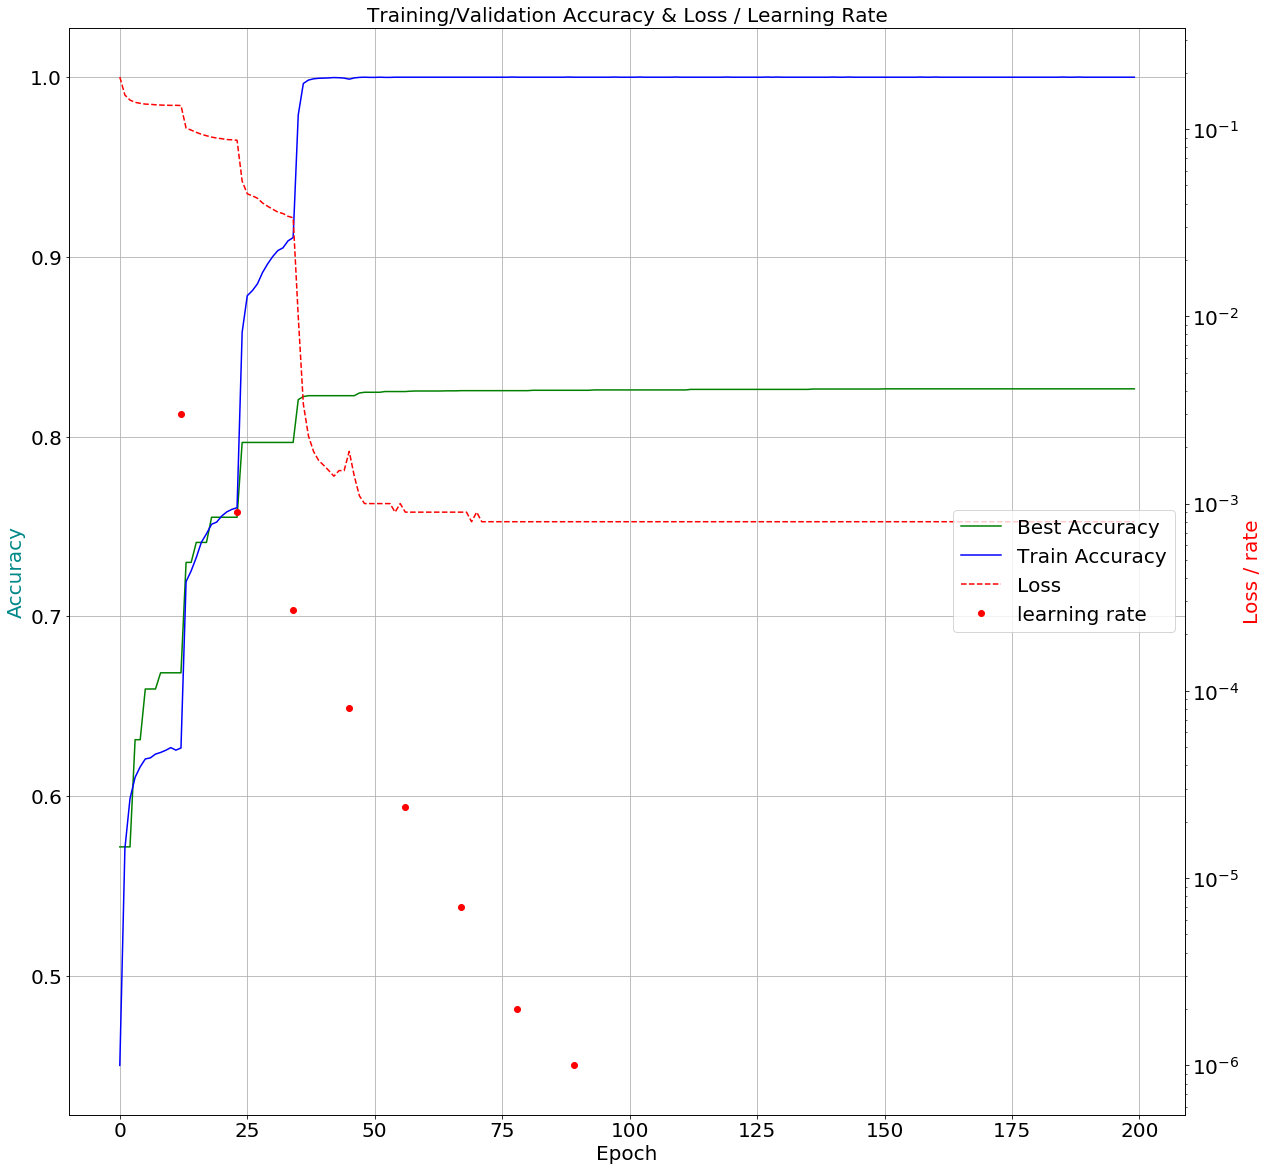

In [120]:
show_train_acc(dictionary_best, dictionary_acc, dictionary_loss, dictionary_lr)